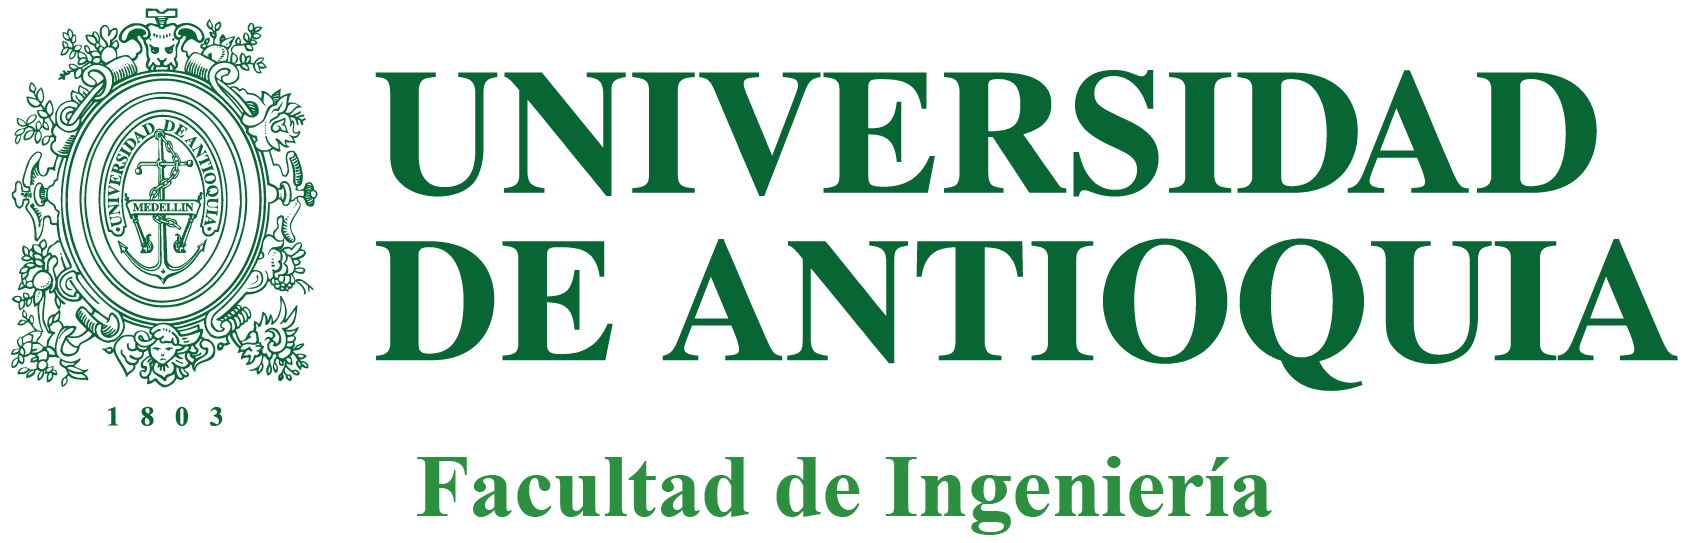


# <font color='2d9040'>**Tercer proyecto: Filtrado de señales ECG**</font>
**Estudiantes:**
- Elisabeth Gomez Cano.
- Marly Alejandra Ortega Andrade.
- Juan Esteban Pineda Lopera.

**Objetivo:** *Implementar un flujo de procesamiento que incluya filtrado de las señales y extracción de características espectrales.*

## Motivación.


Las enfermedades cardiovasculares son una de las principales causas de muerte en todo el mundo, y la Organización Mundial de la Salud (OMS) estimó que 17,9 millones de personas murieron en 2019 por este tipo de enfermedades. Las enfermedades cardiovasculares están relacionadas con problemas de salud que afectan el corazón y los vasos sanguíneos. El riesgo de estas enfermedades aumenta con el tabaquismo, la presión arterial alta, el colesterol alto, una dieta poco saludable, la falta de ejercicio y la obesidad.

El uso de la tecnología puede mejorar los tratamientos sanitarios y el seguimiento con la ayuda de diferentes sensores disponibles en los dispositivos que son cada vez de mayor uso. También, debido al bajo costo de algunos dispositivos de Electrocardiografía (ECG), el personal de salud puede tener a disposición la medición de la actividad eléctrica cardiaca.

Parámetros fisiológicos como la frecuencia cardíaca, la presión arterial y la temperatura corporal que se miden habitualmente en entornos clínicos son muy relevantes, pero estos parámetros tienen alta variabilidad por lo que se requieren mediciones en grandes conjuntos de sujetos de manera que se capture dicha variabilidad para la construcción de modelos.

Sin embargo, el avance en el uso de las bioseñales implica tener los diferentes conjuntos de datos relacionados con diversas enfermedades cardiovasculares debidamente procesadas y etiquetadas, implicando la necesidad de analizar proyectos como MIT-BIH o en Physionet, para disponer de la cantidad de datos necesarios para construir modelos con alto poder diagnóstico o predictivo. El enfoque de grandes volúmenes de datos también permite validar los procedimientos de procesamiento y análisis en diferentes poblaciones
y tecnologías aumentando la pertinencia de las tecnologías desarrolladas.

Un electrocardiograma (ECG) es un registro de la actividad eléctrica del corazón. Se usa ampliamente en entornos clínicos para detectar afecciones cardiovasculares, como ataques cardíacos y alteraciones del ritmo que cambian la actividad eléctrica del corazón. Un ECG se mide colocando electrodos en el pecho y las extremidades de un paciente, que registran diferentes aspectos de la actividad eléctrica de su corazón, y cada aspecto está etiquetado como una derivación.

Un ECG convencional consta de 12 derivaciones, que proporcionan una visión completa de la actividad eléctrica del corazón. Seis de las derivaciones se obtienen colocando cuatro electrodos, uno en cada extremidad, proporcionando las derivaciones I, II, III, VL, VF y VR. Se colocan seis electrodos en el tórax, que proporcionan los cables V1 a V6. La derivación de aplicación más inmediata es la II. La amplitud de la señal del ECG está dentro del rango
de 10 V a 4 mV. La frecuencia más importante de esta señal se encuentra dentro del rango de 0,05 a 100 Hz.

## Entregable

## Importación de las librerias.

In [ ]:
!pip install pywavelets scipy scikit-image --quiet

In [ ]:
import pywt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import seaborn as sns

from zipfile import ZipFile
from scipy.signal import butter, filtfilt, firwin, detrend, welch
from scipy.io import loadmat
from random import choice
from statsmodels.robust import mad
from skimage.restoration import denoise_nl_means, estimate_sigma
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from matplotlib.colors import ListedColormap, BoundaryNorm

## Punto 1.
---
Del [Artículo dado](https://www.nature.com/articles/s41598-020-59821-7): Consultar y explicar los dos métodos de reducción de ruido usados: Robust
LOESS y Non Local Means (10%), y como se pueden implementar en librerías conocidas de
Python (5%)

El artículo propuesto trabaja con un flujo de procesamiento que consistió de un filtro butterworth pasabajas para remover ruido de alta frecuencia, seguido de Robust LOESS para eliminar desviaciones de la linea base y Non Local Means (NLM) para remover el ruido restante, el más aleatorio.

#### Robust LOESS (Local Estimated Scatterplot Smoothing)
Suavizador no paramétrico que recupera la señal inherente de una muestra ruidosa utilizando la regresión lineal en su núcleo. La idea principal es abordar señales altamente no lineales, como las de un motor de vehículo o ECG, utilizando diferentes modelos del mismo tipo para suavizar áreas pequeñas y localizadas de la señal.

Estima cada punto utilizando los puntos vecinos sin asumir una forma global. Genera una ponderación local, se adapta a la forma cercana.

Es *Robust* para que no le afecten los outliers provocado por derivas lentas, es decir, ruidos de baja frecuencia.

https://medium.com/data-science-collective/loess-373d43b03564

Se puede implementar en Python a través de la librería `statsmodels` con la función `lowess`.
```
statsmodels.nonparametric.smoothers_lowess.lowess(
  endog,
  exog,
  frac=0.6666666666666666,
  it=3, delta=0.0,
  xvals=None,
  is_sorted=False,
  missing='drop',
  return_sorted=True)
```

| Parámetro | Tipo  | Descrión  |
| --------- | ----- | ------- |
| `endog`   | array | Variable dependiente (valores y a suavizar). |
| `exog`    | array | Variable independiente (valores x). |
| `frac`    | float | Fracción del total de datos usada para cada estimación local (por defecto: `2/3`). Valores pequeños generan más detalle pero más ruido. |
| `it`      | int   | Número de iteraciones para hacer robusto el suavizado frente a outliers (por defecto: `3`).|
| `delta`   | float | Umbral de distancia para reutilizar pesos previos y acelerar el cálculo (opcional). Valores pequeños hacen el algoritmo más preciso pero más lento. |

Retorna como salida un array 2D de tamaño `(n, 2)`, siendo `n` la cantidad de datos de entrada. La primera columna contiene los valores de la variable independiente `x` también llamada `exog`, mientras que la segunda columna contiene los valores de la variable dependiente `y` o `endog` que es la curva estimada por LOWESS, que sigue la tendencia de los datos pero sin ruido ni oscilaciones fuertes.

https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

#### Non-Local Means.
A diferencia de LOESS, no es local. Observa puntos o zonas similares y las busca en otros puntos de la señal. Compara ventanas alrededor de puntos, dando más peso a ventanas muy similares, sin importar su separación, buscando redundancias o patrones.

La idea central detrás de NLM es reemplazar el valor (por ejemplo, el "color" de un píxel en una imagen o el valor de un punto en una señal) de un píxel o punto dado con un promedio ponderado de los valores de otros píxeles o puntos "similares" en toda la señal. La clave es que estos píxeles o puntos similares no tienen por qué estar físicamente cerca del punto que se está denoizando. Esto permite preservar estructuras repetidas o patrones en la señal que pueden estar distribuidos de forma no local.

https://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf

Aunque no hay una función específica para la aplicación de Non-Local Means en señales, la librería `scikit-image` la implementa para imagenes 2D y 3D, y es posible implementarla para una señal 1D reorganizandola:
```
import numpy as np
from skimage.restoration import denoise_nl_means

# Señal 1D de ejemplo
x = np.array([0.1, 0.15, 0.12, 0.18, 0.3, 0.4, 0.35, 0.32, 0.28])

# Reformula como una "imagen" de una sola fila
x_2d = x[np.newaxis, :]  # forma (1, N)

# Aplica el filtro
x_denoised_2d = denoise_nl_means(
    x_2d,
    patch_size=3,       # tamaño del parche
    patch_distance=5,   # distancia máxima de búsqueda
    h=0.05,             # parámetro de filtro
    fast_mode=True,
    channel_axis=None
)

# Convierte de vuelta a señal 1D
x_denoised = x_denoised_2d[0]
```

| Parámetro        | Tipo        | Descripción                                                                 |
|------------------|-------------|-----------------------------------------------------------------------------|
| `image`          | array       | Array de entrada (en 1D usar `x[np.newaxis, :]`)                           |
| `patch_size`     | int         | Tamaño del parche (debe ser impar)                                         |
| `patch_distance` | int         | Distancia máxima para buscar parches similares                             |
| `h`              | float       | Controla el grado de suavizado (mayor `h` = más suavizado)                 |
| `fast_mode`      | bool        | Si es `True`, usa una versión más rápida (menos precisa)                   |
| `channel_axis`   | int o None  | Eje de los canales de color; usar `None` para datos escalares (como en 1D) |
| `sigma`          | float o None| Desviación estándar del ruido (si se conoce); opcional                     |

Como salida se genera un array suavizado de la misma dimensión y tipo del de entrada.

https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.denoise_nl_means

## Punto 2.
---
Descargar los datos sin filtrar [ECGData.zip](https://www.google.com/url?q=https%3A%2F%2Ffigshare.com%2Fcollections%2FChapmanECG%2F4560497%2F1). De los datos sin filtrar usar los registros que se han usado para análisis en los dos
trabajos previos, para permitir que se pueda comparar entre grupos. **De estos registros los análisis para el presente proyecto deben hacerse en la derivación II**.

### Descarga y lectura de los archivos necesarios

In [ ]:
file_id = '1IhCUZRzL8RkBqlRPpY5boBzukPkjOIqM'
destination = 'Diagnostics.xlsx'

if not os.path.exists(destination):
    print(f"El archivo '{destination}' no encontrado. Descargando...")
    !gdown --id {file_id} --output {destination}
else:
    print(f"El archivo '{destination}' ya está descargado.")


El archivo 'Diagnostics.xlsx' no encontrado. Descargando...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IhCUZRzL8RkBqlRPpY5boBzukPkjOIqM
To: /content/Diagnostics.xlsx
100% 976k/976k [00:00<00:00, 44.7MB/s]


In [ ]:
file_id = '1X73k-U8BrxbY5OKOFRw02bt4M_JNR_yv'
destination = 'ECGData.zip'

if not os.path.exists(destination):
    print(f"El archivo '{destination}' no encontrado. Descargando...")
    !gdown --id {file_id} --output {destination}
else:
    print(f"El archivo '{destination}' ya está descargado.")

zip_path = "ECGData.zip"
extract_to = "ecg_data"

if not os.path.exists(extract_to) or not os.listdir(extract_to):
    print(f"Extrayendo contenido a '{extract_to}'...")
    with ZipFile(destination, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
else:
    print(f"Los archivos ya fueron extraídos en '{extract_to}'.")

El archivo 'ECGData.zip' no encontrado. Descargando...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1X73k-U8BrxbY5OKOFRw02bt4M_JNR_yv
From (redirected): https://drive.google.com/uc?id=1X73k-U8BrxbY5OKOFRw02bt4M_JNR_yv&confirm=t&uuid=0824c5d0-ff2a-467e-a817-a3dd8f4c49dc
To: /content/ECGData.zip
100% 755M/755M [00:09<00:00, 76.7MB/s]
Extrayendo contenido a 'ecg_data'...


In [ ]:
df = pd.read_excel('Diagnostics.xlsx')

display(df)
df.describe()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,MUSE_20181222_204306_99000,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,MUSE_20181222_204309_22000,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,MUSE_20181222_204310_31000,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,MUSE_20181222_204312_58000,SVT,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
count,10646.000000,10646.000000,10646.00000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000
mean,59.186831,84.136107,92.57787,90.989292,384.150855,434.154048,39.620609,44.637704,13.839470,219.260567,264.755213,411.335995
std,18.030019,34.455349,60.09394,17.479540,59.226289,39.354182,41.212648,57.478092,5.676339,6.410413,8.362120,29.777404
min,4.000000,34.000000,0.00000,18.000000,114.000000,219.000000,-89.000000,-89.000000,5.000000,159.000000,249.000000,281.000000
25%,49.000000,57.000000,57.00000,80.000000,344.000000,408.000000,14.000000,19.000000,9.000000,216.000000,259.000000,392.000000
50%,62.000000,73.000000,72.00000,88.000000,390.000000,430.000000,46.000000,42.000000,12.000000,219.000000,264.000000,414.000000
75%,72.000000,104.000000,106.00000,98.000000,426.000000,456.000000,68.000000,62.000000,17.000000,224.000000,268.000000,432.000000
max,98.000000,263.000000,535.00000,256.000000,736.000000,760.000000,270.000000,270.000000,40.000000,240.000000,331.000000,582.000000


### Eliminación de arritmias con pocos sujetos.


In [ ]:
discard = ['SA', 'AT', 'AVNRT', 'SAAWR', 'AVRT']
df = df[~df['Rhythm'].isin(discard)].copy()
url_dict = {}

# Crear diccionario con las URLs por tipo de arritmia
url_dict = {
    rhythm: df[df['Rhythm'] == rhythm]['FileName'].tolist()
    for rhythm in df['Rhythm'].unique()
}

# Verifica cuántas muestras hay por clase (opcional)
for rhythm, urls in url_dict.items():
    print(f"{rhythm}: {len(urls)} archivos")

AFIB: 1780 archivos
SB: 3889 archivos
AF: 445 archivos
SR: 1826 archivos
ST: 1568 archivos
SVT: 587 archivos


## Punto 3.
---
Consultar que tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%).


### **Señales Wavelet aplicadas al análisis de ECG**


El análisis wavelet es una técnica especialmente útil para el tratamiento de señales no estacionarias como el electrocardiograma (ECG), ya que permite descomponer la señal en diferentes niveles de resolución, facilitando tanto la detección de eventos transitorios como la eliminación de ruido sin afectar la morfología característica de las ondas P, QRS y T [1].

Entre las familias de wavelets más empleadas para el análisis de señales ECG se encuentran:

**Daubechies (db)**: Esta familia es ampliamente utilizada en aplicaciones biomédicas por su buena localización en el tiempo y su capacidad para representar las discontinuidades abruptas como las del complejo QRS. En particular, la wavelet db4 ha demostrado ser efectiva para la detección de QRS y reducción de ruido [2].

**Symlets (sym):** Son una variante simétrica de las Daubechies, lo cual favorece una reconstrucción más fiel de la morfología de la señal. Las sym5 y sym8 son populares en tareas donde se busca preservar tanto los picos como las formas suaves de las ondas [3].

**Coiflets (coif):** Presentan mayor número de momentos nulos, lo que proporciona una mejor aproximación de las formas suaves de la señal, como la onda T. También ofrecen una relación balanceada entre la precisión en tiempo y frecuencia [4].

**Biorthogonal (bior)**: Estas wavelets permiten una reconstrucción exacta gracias a su simetría perfecta. Se utilizan cuando se desea mantener la integridad morfológica de la señal ECG, como en aplicaciones clínicas o de compresión con mínima distorsión [5].

**Meyer y Discrete Meyer (dmey)**: Aunque menos comunes, estas wavelets ofrecen suavidad y continuidad en la frecuencia, siendo útiles para el análisis global de la señal o para detectar anomalías que se distribuyen en todo el espectro [6].

La elección de la wavelet depende directamente del objetivo del análisis: por ejemplo, para detección precisa de QRS se recomienda db4 o sym5, mientras que para aplicaciones de limpieza de ruido preservando forma se recomiendan bior4.4 o coif5 [1][2][3]. Cada una tiene ventajas dependiendo del tipo de distorsión presente (ruido muscular, interferencia de línea base, etc.) y del componente ECG que se desee preservar.

[1] https://pmc.ncbi.nlm.nih.gov/articles/PMC4701319/

[2] https://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0718-07642018000300145

[3] https://www.mdpi.com/2411-9660/5/3/41

[4] https://www.mdpi.com/1099-4300/18/8/285

[5] https://builtin.com/data-science/wavelet-transform

[6] https://www.sciencedirect.com/science/article/pii/S2214180422000319

### Código módificado.

Por su utilida y eficiencia en la reducción de ruido en los complejos QRS, se trabajara con db4, de la familia Daubechies.

In [ ]:
def wnoisest(coeffs):
    return np.array([mad(c) / 0.6745 for c in coeffs])  # estimación robusta del ruido

def threshold(coeffs):
    num_samples = sum(c.size for c in coeffs)
    return np.sqrt(2 * np.log(num_samples))  # umbral universal

def get_signal(signal_or_path):
    # Si ya es un array o lista, devolver como array
    if isinstance(signal_or_path, (np.ndarray, list)):
        return np.asarray(signal_or_path)

    # Si es un string, se asume que es una ruta o nombre de archivo
    if isinstance(signal_or_path, str):
        try:
            df = pd.read_csv(f'ecg_data/ECGData/{signal_or_path}.csv', header=None,
                             names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            signal = pd.to_numeric(df['II'], errors='coerce').dropna().to_numpy()

            if signal.size == 0 or np.sum(signal) == 0:
                print(f"La señal '{signal_or_path}' está vacía o no contiene datos válidos.")
                return None

            return signal

        except Exception as e:
            print(f"Error al leer la señal desde '{signal_or_path}': {e}")
            return None

    # Otro tipo no reconocido
    raise ValueError(f"Tipo de dato no reconocido para la señal: {type(signal_or_path)}")

def get_signal_denoised(signal_or_path):
    # Si ya es un array o lista, devolver como array
    if isinstance(signal_or_path, (np.ndarray, list)):
        return np.asarray(signal_or_path)

    # Si es un string, se asume que es una ruta o nombre de archivo
    if isinstance(signal_or_path, str):
        try:
            df = pd.read_csv(f'ecg_data_denoised/ECGDataDenoised/{signal_or_path}.csv', header=None,
                             names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            signal = pd.to_numeric(df['II'], errors='coerce').dropna().to_numpy()

            if signal.size == 0 or np.sum(signal) == 0:
                print(f"La señal '{signal_or_path}' está vacía o no contiene datos válidos.")
                return None

            return signal

        except Exception as e:
            print(f"Error al leer la señal desde '{signal_or_path}': {e}")
            return None

    # Otro tipo no reconocido
    raise ValueError(f"Tipo de dato no reconocido para la señal: {type(signal_or_path)}")


def wavelet_denoise(signal, level=4, wavelet='db4', plot=False):
    """
    Filtra una señal 1D usando descomposición wavelet y umbralización dura.

    Parámetros:
    - url: path o array de la señal a procesar.
    - wavelet: str, nombre del wavelet (ej. 'db6', 'sym4', etc). Predeterminado db4.
    - plot: bool, si es True, muestra gráficas del proceso.

    Retorna:
    - resultas: diccionario con la señal original y resultados del filtrado.
    """
    results = {}
    # Lectura de la señal a través del URL y estracción de la derivación II
    signal = get_signal(signal)
    if signal is None:
        return None

    # Estimación del nivel de descomposición máximo recomendado por PyWavelet
    level_max = pywt.dwt_max_level(data_len=len(signal),
                                  filter_len=pywt.Wavelet(wavelet).dec_len)

    # Elección del nivel, asegurandose de que el ingresado no sea mayor al máximo
    level = np.min([level, level_max])
    # Descomposición wavelet
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    approx = coeffs[0]
    details = coeffs[1:]

    # Estimación de ruido y umbral
    noise_std = wnoisest(details)
    thr = threshold(details)

    # Umbralización dura
    details_thresh = [
        d * (np.abs(d) > thr * s) for d, s in zip(details, noise_std)
    ]

    # Reconstrucción
    coeffs_filt = [approx] + details_thresh
    x_rec = pywt.waverec(coeffs_filt, wavelet)
    x_rec = x_rec[:len(signal)]
    x_filt = signal - x_rec
    results = {
        'señal': signal,
        'reconstruida': x_rec,
        'ruido': x_filt,
    }

    if plot:
        # Graficar detalles originales vs umbralizados
        n = len(details)
        plt.figure(figsize=(24, 6))
        for i in range(n):
            plt.subplot(2, n, i+1)
            plt.plot(details[i], label='Original', color='black', linewidth=0.5)
            umbral = thr * noise_std[i]
            plt.axhline(y=umbral, color='r', linestyle='--', linewidth=1, label='Umbral +')
            plt.axhline(y=-umbral, color='r', linestyle='--', linewidth=1, label='Umbral -')
            plt.title(f'Detalle D{level - i}')
            plt.legend(fontsize='x-small')

            plt.subplot(2, n, n + i + 1)
            plt.plot(details_thresh[i], color='black', linewidth=0.5)
            plt.title(f'Filtrado D{level - i}')
        plt.tight_layout()
        plt.show()

        # Graficar señal original, reconstruida y diferencia
        plt.figure(figsize=(8,4))
        plt.plot(signal, label='Original', color='black')
        plt.plot(x_rec, label='Filtrada', color='red')
        plt.legend()
        plt.title('Señal Original vs Filtrada')
        plt.xlim(0, 1000)
        plt.grid()
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(x_filt, label='Diferencia (Ruido eliminado)')
        plt.title('Ruido estimado')
        plt.grid()
        plt.show()

    return results

### Prueba del filtro wavelet modificado.

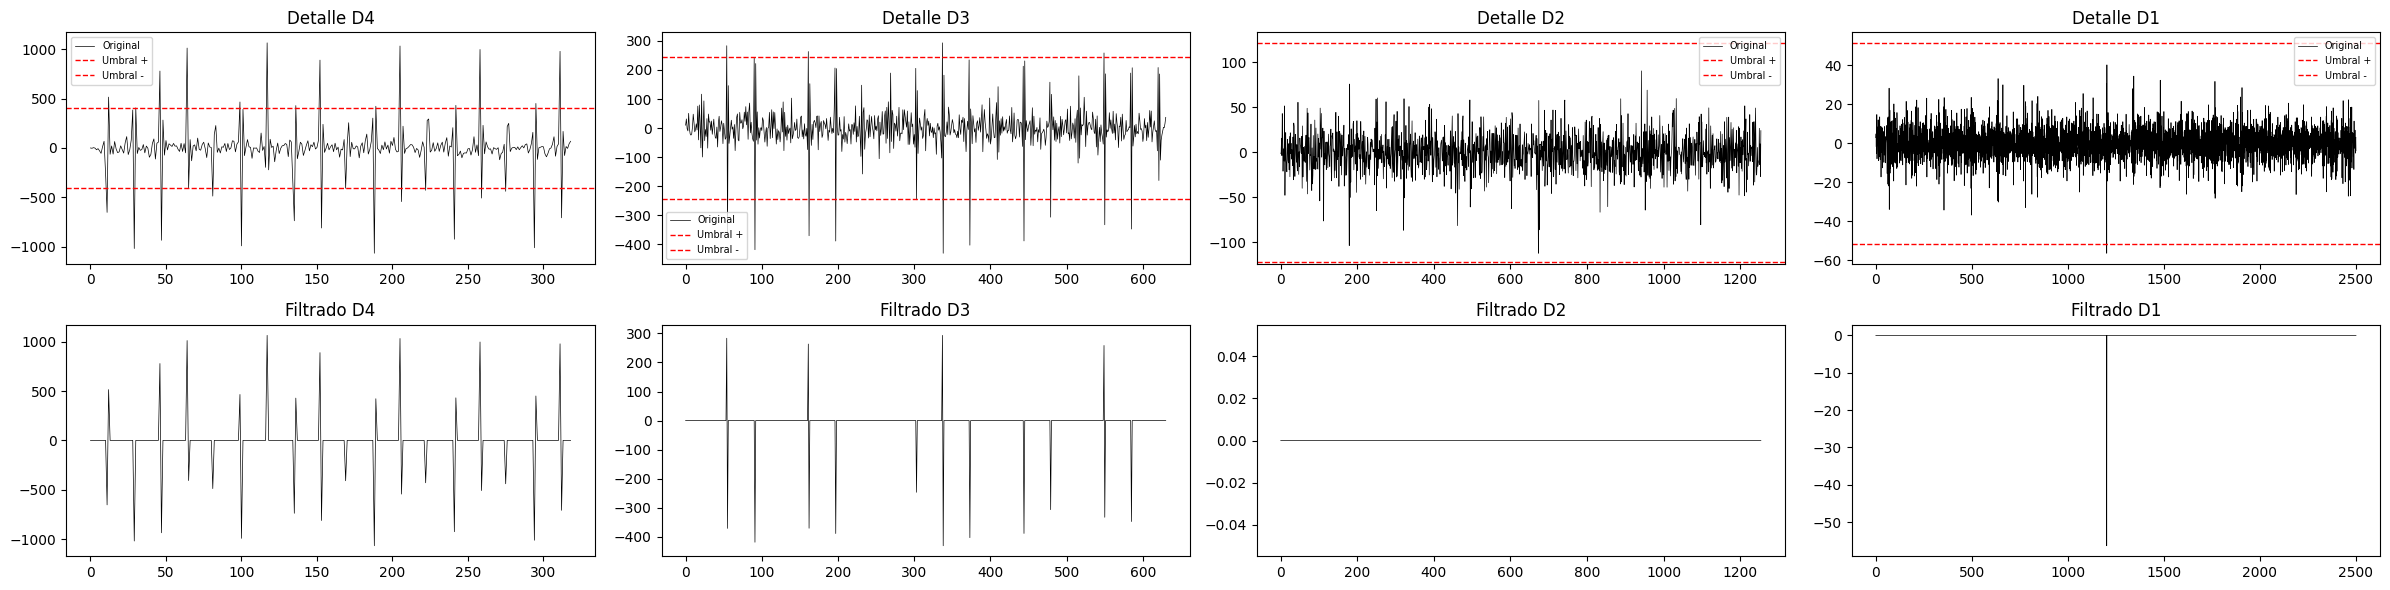

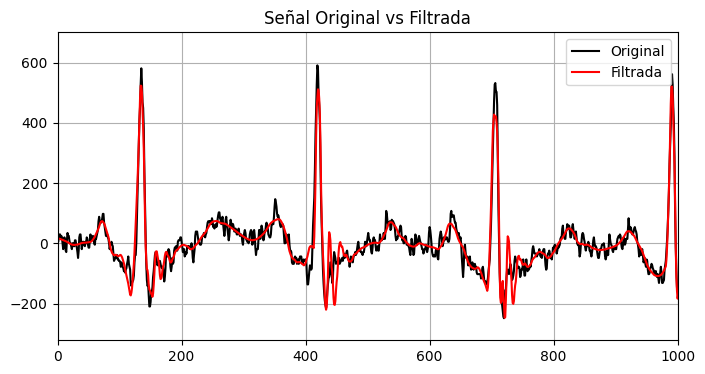

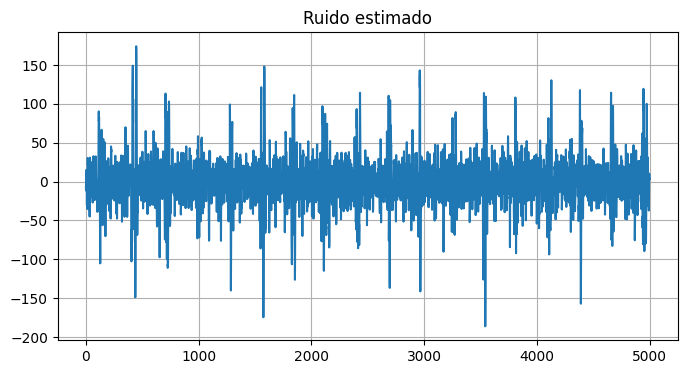

In [ ]:
samples = []
keys = list(url_dict.keys())

while len(samples) < 1:
    key = choice(keys)
    values = url_dict[key]
    if values:
        samples.append(choice(values))

for sample in samples:
  wavelet_denoise(sample, level = 4, plot=True)

## Punto 4.
---
Escoger 10 señales al azar y aplicar cada uno de los 3 flujos de procesamiento propuestos. Describir los resultados obtenidos y justificar con cual de los flujos se hará el resto del trabajo (20%). Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip (sin procesar) derivación II que correspondan a las mismas usadas en los proyectos previos.


In [ ]:
samples = []
keys = list(url_dict.keys())

while len(samples) < 10:
    key = choice(keys)
    values = url_dict[key]
    if values:
        samples.append(choice(values))

### Flujo 1.
- Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros.
- Filtro wavelet modificado del punto 3.
- Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR.


In [ ]:
def highpass_IIRfilter(signal, fs=500, cutoff=0.5, order=4):
    signal = get_signal(signal)
    if signal is None:
        return None

    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

def lowpass_IIRfilter(signal, fs=500, cutoff=50, order=4):
    signal = get_signal(signal)
    if signal is None:
        return None

    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

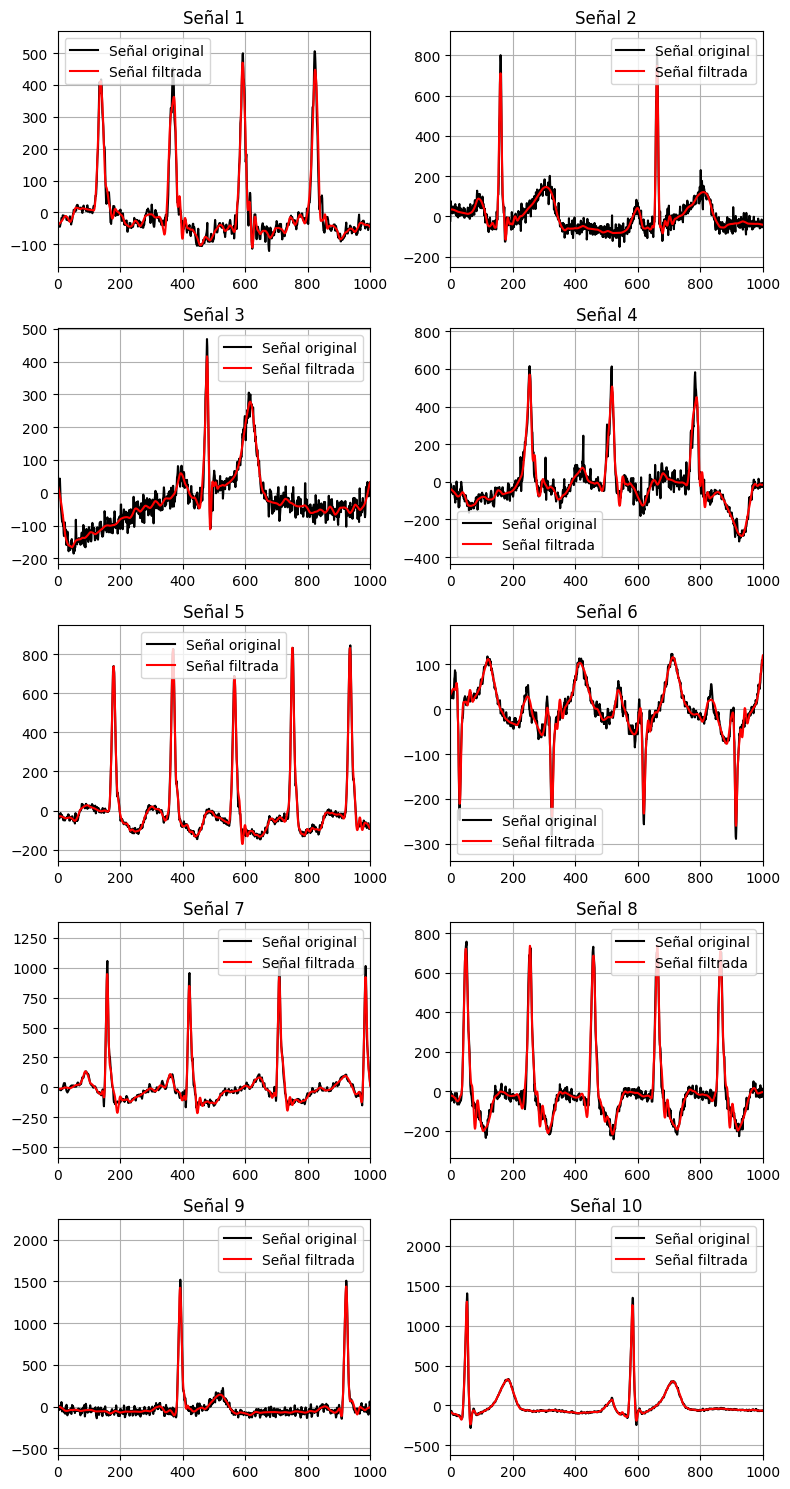

In [ ]:
plt.figure(figsize=(8, 15))
i = 0

for sample1 in samples:
  sample1 = highpass_IIRfilter(sample1)
  sample1 = wavelet_denoise(sample1, level = 4, plot=False)
  sample1['reconstruida'] = lowpass_IIRfilter(sample1['reconstruida'])

  plt.subplot(5, 2, i + 1)
  plt.plot(sample1['señal'], color='black', label='Señal original')
  plt.plot(sample1['reconstruida'], color='red', label='Señal filtrada')
  plt.xlim(0, 1000)
  plt.title(f'Señal {i + 1}')
  plt.legend()
  plt.grid(True)

  i += 1

plt.tight_layout()
plt.show()

### Flujo 2.
- Detrend.
- Filtro wavelet modificado del punto 3.
- Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR.

In [ ]:
def lowpass_FIRfilter(signal, fs=500, cutoff=50, order=32):
    signal = get_signal(signal)
    if signal is None:
        return None

    nyq = 0.5 * fs
    taps = firwin(order + 1, cutoff / nyq, pass_zero='lowpass', window='hamming')
    return filtfilt(taps, [1.0], signal)


def path_detrend(signal):
    signal = get_signal(signal)
    if signal is None:
        return None

    return detrend(signal)

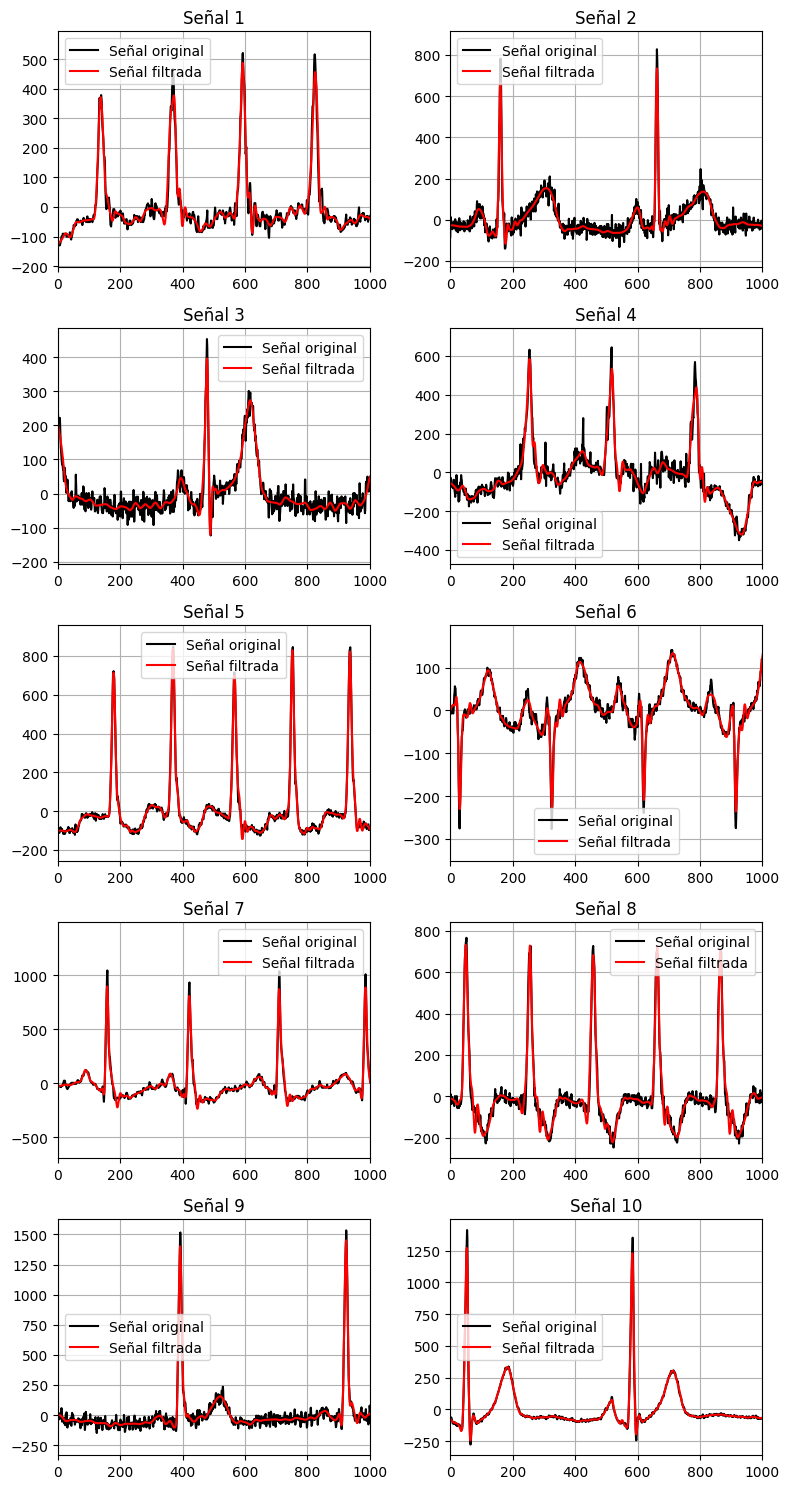

In [ ]:
plt.figure(figsize=(8, 15))
i = 0

for sample2 in samples:
  sample2 = path_detrend(sample2)
  sample2 = wavelet_denoise(sample2, level = 4, plot=False)
  sample2['reconstruida'] = lowpass_FIRfilter(sample2['reconstruida'])

  plt.subplot(5, 2, i + 1)
  plt.plot(sample2['señal'], color='black', label='Señal original')
  plt.plot(sample2['reconstruida'], color='red', label='Señal filtrada')
  plt.xlim(0, 1000)
  plt.title(f'Señal {i + 1}')
  plt.legend()
  plt.grid(True)

  i += 1

plt.tight_layout()
plt.show()

### Flujo 3.
-  Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR.
- Filtrado LOESS.
- Filtrado NLM.


In [ ]:
def loess_filter(signal):
    signal = get_signal(signal)
    if signal is None:
        return None

    t = np.arange(len(signal))
    baseline = lowess(signal, t, frac=2/3, it=3, return_sorted=False)
    return signal - baseline

def nlm_filter(signal):
    signal = get_signal(signal)
    if signal is None:
        return None

    # Convertir a tipo float y normalizar entre 0 y 1
    signal_norm = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    # Expandir a 2D temporalmente (1 fila, N columnas)
    signal_2d = np.expand_dims(signal_norm, axis=0)
    # Estimar sigma del ruido
    sigma_est = np.std(signal_2d)
    # Aplicar filtro NLM 2D
    filtered_2d = denoise_nl_means(signal_2d, h=0.8 * sigma_est, fast_mode=True, patch_size=5, patch_distance=6, channel_axis=None)
    # Volver a convertir a 1D
    filtered_1d = np.squeeze(filtered_2d)
    # Restaurar escala original
    filtered_1d = filtered_1d * (np.max(signal) - np.min(signal)) + np.min(signal)
    return filtered_1d

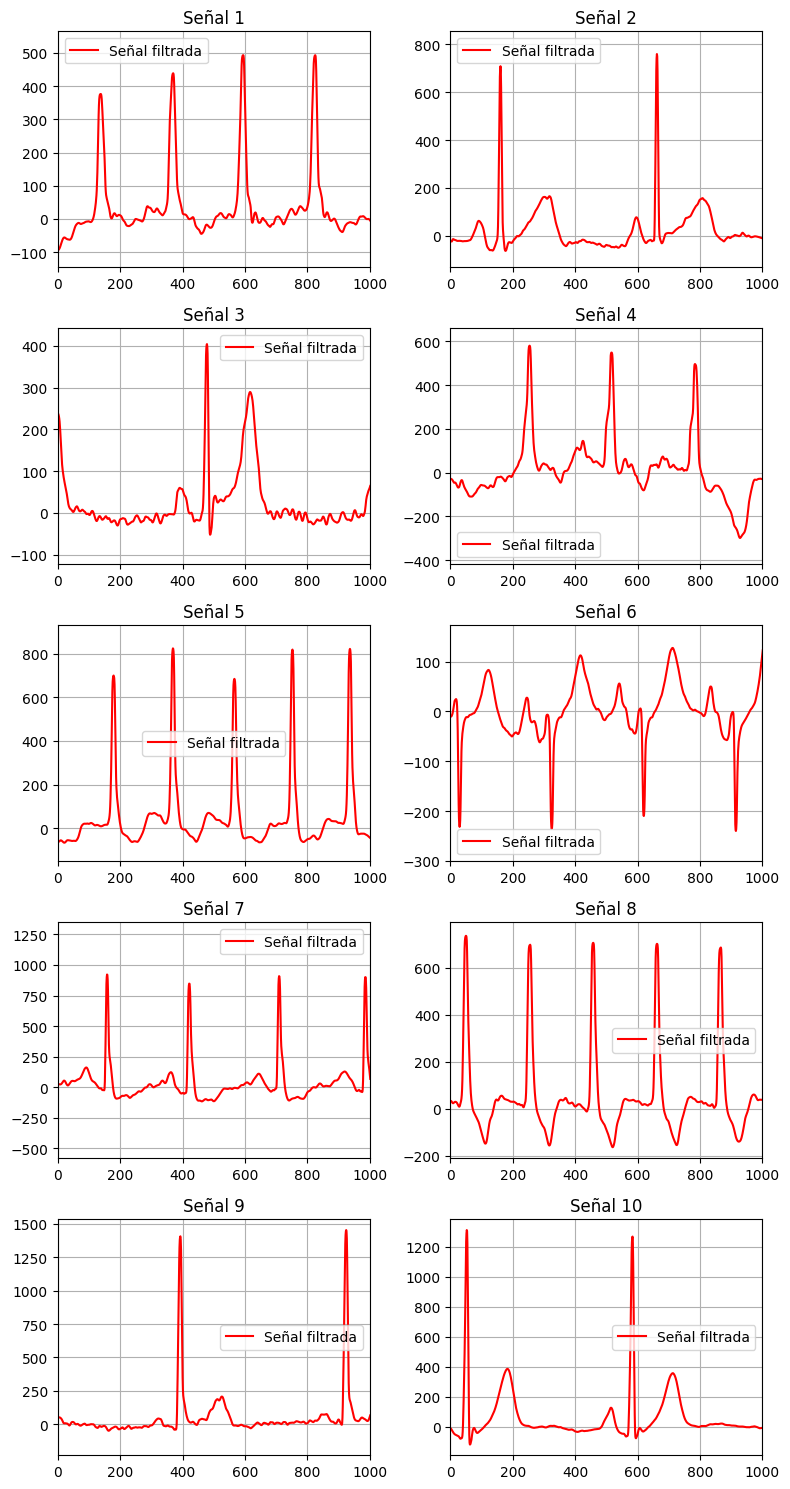

In [ ]:
plt.figure(figsize=(8, 15))
i = 0

for sample3 in samples:
  sample3 = lowpass_IIRfilter(sample3)
  sample3 = loess_filter(sample3)
  sample3 = nlm_filter(sample3)

  plt.subplot(5, 2, i + 1)
  plt.plot(sample3, color='red', label='Señal filtrada')
  plt.xlim(0, 1000)
  plt.title(f'Señal {i + 1}')
  plt.legend()
  plt.grid(True)

  i += 1

plt.tight_layout()
plt.show()

### Comparación.

In [ ]:
def comparison(sample, clase):
    resultados = []
    if isinstance(sample, str):
        try:
            df = pd.read_csv(f'ecg_data/ECGData/{sample}.csv', header=None,
                            names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            ecg = pd.to_numeric(df['II'], errors='coerce').dropna().to_numpy()

            if ecg.size == 0 or np.sum(ecg) == 0:
                print(f"La señal '{sample}' está vacía o no contiene datos válidos.")
                ecg = None

        except Exception as e:
            print(f"Error al leer la señal desde '{sample}': {e}")
            ecg = None

    # Aplicar cada flujo
    f1 = highpass_IIRfilter(ecg)
    f1 = wavelet_denoise(f1, level = 4, plot=False)
    f1 = lowpass_IIRfilter(f1['reconstruida'])

    f2 = path_detrend(ecg)
    f2 = wavelet_denoise(f2, level = 4, plot=False)
    f2 = lowpass_FIRfilter(f2['reconstruida'])

    f3 = lowpass_IIRfilter(ecg)
    f3 = loess_filter(f3)
    f3 = nlm_filter(f3)

    resultados.append({
      'archivo': sample,
      'clase': clase,
      'original': ecg,
      'flujo1': f1,
      'flujo2': f2,
      'flujo3': f3
    })
    return resultados

In [ ]:
samples = []
keys = list(url_dict.keys())

while len(samples) < 10:
    key = choice(keys)
    values = url_dict[key]
    samples.append({'Señal': choice(values), 'Ritmo': key})

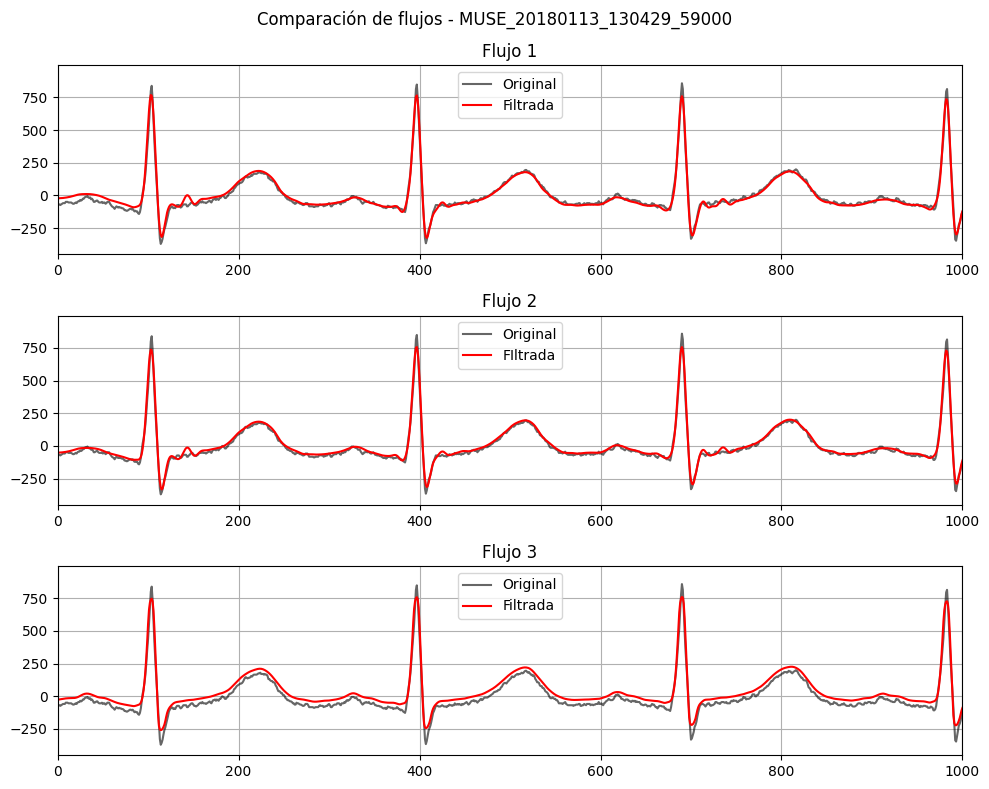

In [ ]:

ejemplo = comparison(samples[0]['Señal'], samples[0]['Ritmo'])[0]

plt.figure(figsize=(10, 8))
plt.suptitle(f"Comparación de flujos - {ejemplo['archivo']}")

plt.subplot(3, 1, 1)
plt.plot(ejemplo['original'], label='Original', alpha=0.6, color='black')
plt.plot(ejemplo['flujo1'], label='Filtrada', color='red')
plt.legend()
plt.title("Flujo 1")
plt.xlim(0, 1000)
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(ejemplo['original'], label='Original', alpha=0.6, color='black')
plt.plot(ejemplo['flujo2'], label='FIltrada', color='red')
plt.legend()
plt.title("Flujo 2")
plt.xlim(0, 1000)
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(ejemplo['original'], label='Original', alpha=0.6, color='black')
plt.plot(ejemplo['flujo3'], label='Filtrada', color='red')
plt.legend()
plt.title("Flujo 3")
plt.xlim(0, 1000)
plt.grid()

plt.tight_layout()
plt.show()


## Punto 5.
---
Para cada señal extraer la frecuencia que contiene la máxima potencia usando
Welch (15%)

In [ ]:
def obtener_frecuencia_max_potencia(signal, fs=500):
    """
    Calcula la frecuencia de máxima potencia usando el método de Welch.
    """
    freqs, psd = welch(signal, fs=fs, nperseg=1024)
    fmp = freqs[np.argmax(psd)]
    return fmp

## Punto 6.
---
Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):

| Registro | Estado | fMP |
|----------|----------|----------|
|    |    |    |
|    |    |    |
|    |    |    |


El flujo seleccionado fue el flujo 2, y el código usado para el procesamiento fue el siguiente:

    from tqdm import tqdm

    df_fmp = []

    # Contar el total de iteraciones
    total = sum(len(urls) for urls in url_dict.values())

    # Agregar tqdm al iterador
    with tqdm(total=total, desc="Procesando señales", unit="archivo") as pbar:
        for rhythm, urls in url_dict.items():
            for url in urls:
                resultados = comparison(url, rhythm)

                for entrada in resultados:
                    archivo = entrada['archivo']
                    clase = entrada['clase']

                    # Aquí cambiar el flujo si corresponde
                    señal_filtrada = entrada['flujo2']

                    fmp = obtener_frecuencia_max_potencia(señal_filtrada)

                    df_fmp.append({
                        'Registro': archivo,
                        'Clase': clase,
                        'fMP': fmp
                    })

                    pbar.update(1)  # Avanza una unidad en la barra
Posteriormente, se guarda un archivo csv para poder cargar los datos obtenidos cuando sea necesario:

    df_full_fmp = pd.DataFrame(df_full_fmp)
    display(df_full_fmp)


    df_full_fmp.to_csv("fmp.csv", index=False)


In [ ]:
# Descarga de los datos (en colab):
file_id = '19oeTCbhk0WygDOrj7AyEIXY03fidszk7'
destination = 'fmp.csv'

if not os.path.exists(destination):
    print(f"El archivo '{destination}' no encontrado. Descargando...")
    !gdown --id {file_id} --output {destination}
else:
    print(f"El archivo '{destination}' ya está descargado.")

El archivo 'fmp.csv' no encontrado. Descargando...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19oeTCbhk0WygDOrj7AyEIXY03fidszk7
To: /content/fmp.csv
100% 410k/410k [00:00<00:00, 8.75MB/s]


In [ ]:
# Cargar el archivo
df_full_fmp = pd.read_csv('fmp.csv')

display(df_full_fmp)
df_full_fmp.describe()

,Registro,Clase,fMP
0,MUSE_20180113_171327_27000,AFIB,0.488281
1,MUSE_20180114_075026_69000,AFIB,4.394531
2,MUSE_20180113_133901_16000,AFIB,0.976562
3,MUSE_20180116_123940_90000,AFIB,0.488281
4,MUSE_20180114_075003_61000,AFIB,3.906250
...,...,...,...
10090,MUSE_20181222_204306_99000,SVT,3.417969
10091,MUSE_20181222_204309_22000,SVT,2.929688
10092,MUSE_20181222_204310_31000,SVT,2.441406
10093,MUSE_20181222_204312_58000,SVT,2.929688


,fMP
count,10095.000000
mean,3.030246
std,2.336023
min,0.000000
25%,0.976562
50%,2.441406
75%,4.394531
max,16.601562


## Punto 7.
---
Comparar los resultados de fMP del proyecto 3 con los que se obtendrían de las
señales filtradas, usadas en los proyectos anteriores, usando estadística
descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de arritmias con el flujo de procesamiento usados en el presente proyecto respecto al que tenían originalmente las señales usadas en el proyecto 2.




### Lectura de los datos con el filtrado original y se procesan para obtener fMP.

El código para la carga de los datos usados en los proyectos anteriores y la extración del fMP fue el siguiente:

    # Se realiza la carga de archivos al entorno
    file_id = '1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l'
    destination = 'ECGDataDenoised.zip'
    if not os.path.exists(destination):
        print(f"El archivo '{destination}' no encontrado. Descargando...")
        !gdown {file_id} --output {destination}
    else:
        print(f"El archivo '{destination}' ya está descargado.")

    zip_path = "ECGDataDenoised.zip"
    extract_to = "ecg_data_denoised"

    if not os.path.exists(extract_to) or not os.listdir(extract_to):
        print(f"Extrayendo contenido a '{extract_to}'...")
        with ZipFile(destination, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
    else:
        print(f"Los archivos ya fueron extraídos en '{extract_to}'.")

    discard = ['SA', 'AT', 'AVNRT', 'SAAWR', 'AVRT']
    df = df[~df['Rhythm'].isin(discard)].copy()
    url_dict = {}

    # Crear diccionario con las URLs por tipo de arritmia
    url_dict = {
        rhythm: df[df['Rhythm'] == rhythm]['FileName'].tolist()
        for rhythm in df['Rhythm'].unique()
    }

    # Verifica cuántas muestras hay por clase (opcional)
    for rhythm, urls in url_dict.items():
        print(f"{rhythm}: {len(urls)} archivos")

    df_full_fmp = []

    # Contar el total de iteraciones
    total = sum(len(urls) for urls in url_dict.values())

    # Agregar tqdm al iterador
    with tqdm(total=total, desc="Procesando señales", unit="archivo") as pbar:
        for rhythm, urls in url_dict.items():
            for url in urls:
              signal = get_signal_denoised(url)

              if signal is not None:
                fmp = obtener_frecuencia_max_potencia(signal)

                df_full_fmp.append({
                    'Registro': url,
                    'Clase': rhythm,
                    'fMP': fmp
                })

              pbar.update(1)  # Avanza una unidad en la barra

Posteriormente se almacenaron los datos en un csv para su posterior carga:

    df_full_fmp = pd.DataFrame(df_full_fmp)

    df_full_fmp.to_csv("fmp_denoised.csv", index=False)
    display(df_full_fmp)
    df_full_fmp.describe()

In [ ]:
# Descarga de los datos (en colab):
file_id = '1WMhVZVdlOfENGXhIhZnAShgTrbzCRu_W'
destination = 'fmp_denoised.csv'

if not os.path.exists(destination):
    print(f"El archivo '{destination}' no encontrado. Descargando...")
    !gdown --id {file_id} --output {destination}
else:
    print(f"El archivo '{destination}' ya está descargado.")

El archivo 'fmp_denoised.csv' no encontrado. Descargando...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WMhVZVdlOfENGXhIhZnAShgTrbzCRu_W
To: /content/fmp_denoised.csv
100% 406k/406k [00:00<00:00, 13.1MB/s]


In [ ]:
# Cargar el archivo
df_full_fmp_denoised = pd.read_csv('fmp_denoised.csv')

display(df_full_fmp_denoised)
df_full_fmp_denoised.describe()

,Registro,Clase,fMP
0,MUSE_20180113_171327_27000,AFIB,13.183594
1,MUSE_20180114_075026_69000,AFIB,4.394531
2,MUSE_20180113_133901_16000,AFIB,3.906250
3,MUSE_20180116_123940_90000,AFIB,1.464844
4,MUSE_20180114_075003_61000,AFIB,3.906250
...,...,...,...
10050,MUSE_20180712_151739_84000,SVT,6.347656
10051,MUSE_20180712_151741_98000,SVT,5.859375
10052,MUSE_20180712_151744_19000,SVT,3.417969
10053,MUSE_20180712_151746_33000,SVT,2.441406


,fMP
count,10055.000000
mean,4.034111
std,2.541496
min,0.488281
25%,2.441406
50%,3.417969
75%,4.882812
max,49.804688


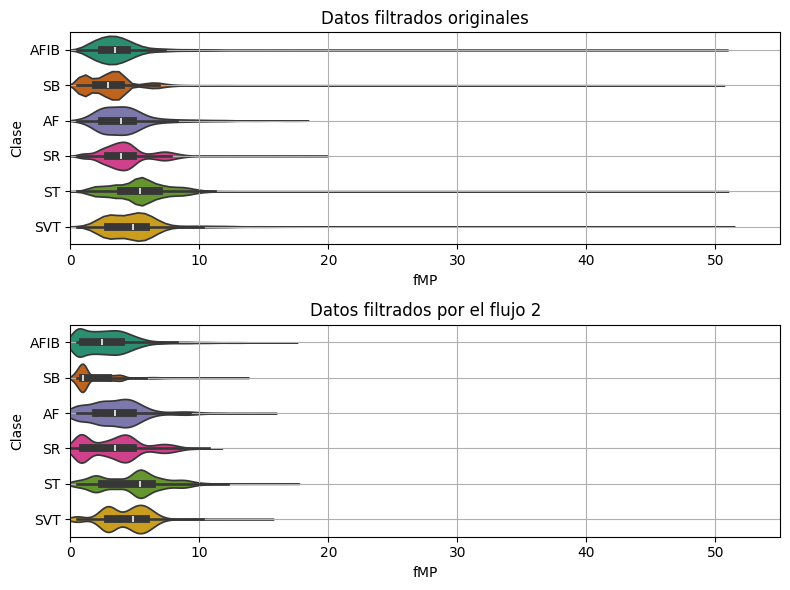

In [ ]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.title('Datos filtrados originales')
ax = sns.violinplot(
    data=df_full_fmp_denoised,
    x='fMP',
    y='Clase',
    hue='Clase',
    inner='box',
    palette='Dark2',
    legend=False
)
plt.xlim(0, 55)
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Datos filtrados por el flujo 2')
ax = sns.violinplot(
    data=df_full_fmp,
    x='fMP',
    y='Clase',
    hue='Clase',
    inner='box',
    palette='Dark2',
    legend=False
)
plt.xlim(0, 55)
plt.grid()

plt.tight_layout()
plt.show()

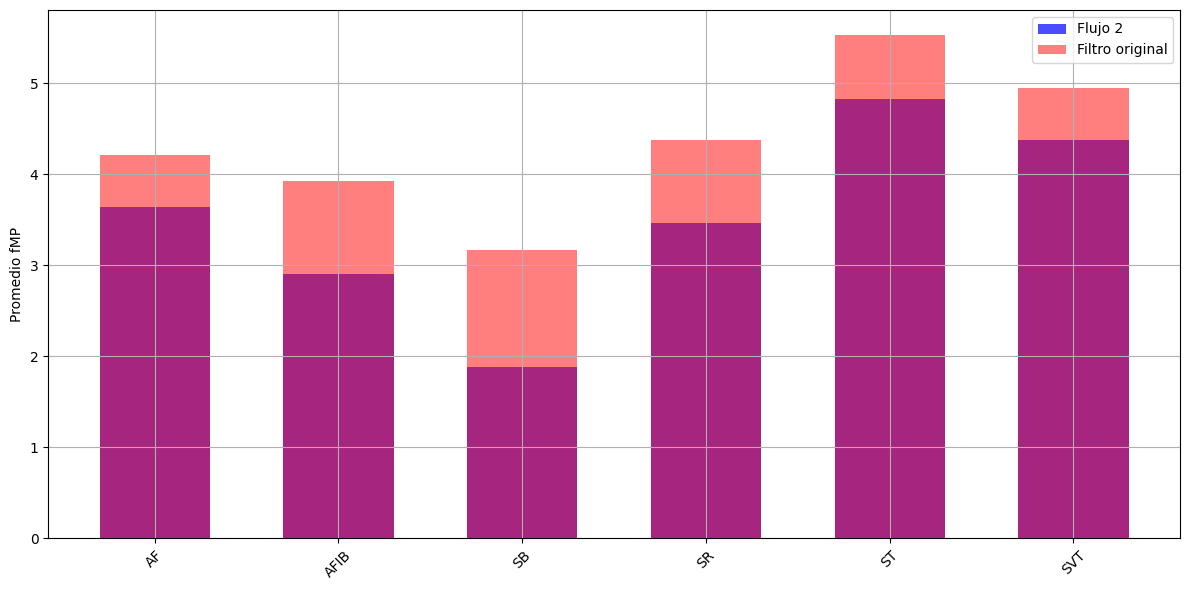

In [ ]:
# Agrupar por clase y calcular promedio de fMP
mean_df1 = df_full_fmp.groupby("Clase")["fMP"].mean()
mean_df2 = df_full_fmp_denoised.groupby("Clase")["fMP"].mean()

# Unir clases de ambos dataframes y ordenarlas
clases = sorted(set(mean_df1.index).union(mean_df2.index))

# Alinear los valores en el mismo orden
valores1 = [mean_df1.get(clase, np.nan) for clase in clases]
valores2 = [mean_df2.get(clase, np.nan) for clase in clases]

# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar las barras una encima de otra con transparencia
bar_width = 0.6
x = np.arange(len(clases))

plt.bar(x, valores1, width=bar_width, label='Flujo 2', alpha=0.7, color='blue')
plt.bar(x, valores2, width=bar_width, label='Filtro original', alpha=0.5, color='red')

plt.xticks(x, clases, rotation=45)
plt.ylabel("Promedio fMP")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


### Comparación de la métrica entre los filtros.

In [ ]:
def matriz_comparativa(df, metrica='fMP', alpha=0.05):
    # Asegurarse de que el dataframe contiene lo necesario
    if not all(col in df.columns for col in ['Clase', metrica]):
        raise ValueError("El dataframe debe contener las columnas 'Clase' y la métrica especificada.")

    # Agrupar por clases
    clases = sorted(df['Clase'].unique())
    grupos = {clase: df[df['Clase'] == clase][metrica].dropna() for clase in clases}

    # Crear matriz vacía
    matriz_pvalores = pd.DataFrame(index=clases, columns=clases, dtype=object)
    valores_p = []

    # Comparaciones por pares
    for clase1 in clases:
        datos1 = grupos[clase1]
        stat, p_norm = shapiro(datos1)

        if p_norm > alpha:
            # Distribución normal → pruebas paramétricas
            for clase2 in clases:
                if clase1 == clase2:
                    matriz_pvalores.loc[clase1, clase2] = "-"
                else:
                    datos2 = grupos[clase2]
                    _, p_homo = levene(datos1, datos2)
                    if p_homo < alpha:
                        _, p_valor = ttest_ind(datos1, datos2, equal_var=False)
                    else:
                        _, p_valor = ttest_ind(datos1, datos2, equal_var=True)

                    valores_p.append(p_valor)
                    decision = "H1" if p_valor < alpha else "H0"
                    matriz_pvalores.loc[clase1, clase2] = f"{p_valor:.2e}\n{decision}"
        else:
            # No normal → prueba de Mann-Whitney
            for clase2 in clases:
                if clase1 == clase2:
                    matriz_pvalores.loc[clase1, clase2] = "-"
                else:
                    datos2 = grupos[clase2]
                    _, p_valor = mannwhitneyu(datos1, datos2, alternative='two-sided')
                    valores_p.append(p_valor)
                    decision = "H1" if p_valor < alpha else "H0"
                    matriz_pvalores.loc[clase1, clase2] = f"{p_valor:.2e}\n{decision}"

    # Crear matriz numérica para heatmap
    matriz_numerica = matriz_pvalores.copy()
    for i in matriz_numerica.index:
        for j in matriz_numerica.columns:
            if matriz_numerica.loc[i, j] != "-":
                matriz_numerica.loc[i, j] = float(matriz_pvalores.loc[i, j].split("\n")[0])
            else:
                matriz_numerica.loc[i, j] = np.nan
    matriz_numerica = matriz_numerica.astype(float)

    # Calcular y mostrar promedio de p-valores (excluyendo NaN)
    promedio_p = np.nanmean(matriz_numerica.values)
    print(f"\nPromedio de p-valores (excluyendo la diagonal): {promedio_p:.4f}")

    # Escala de colores
    boundaries = [0, 0.01, 0.025, 0.05, 1.0]
    colors = ["#08306b", "#2171b5", "#deebf7", "#f03b20"]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, len(colors))

    # Plot
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        matriz_numerica,
        annot=matriz_pvalores,
        fmt="",
        cmap=cmap,
        norm=norm,
        cbar=True,
        square=True,
        linewidths=0.5,
        linecolor='gray',
        annot_kws={"size": 8}
    )

    ax.set_title(f"Matriz de p-valores - {metrica}", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()



Promedio de p-valores (excluyendo la diagonal): 0.0134


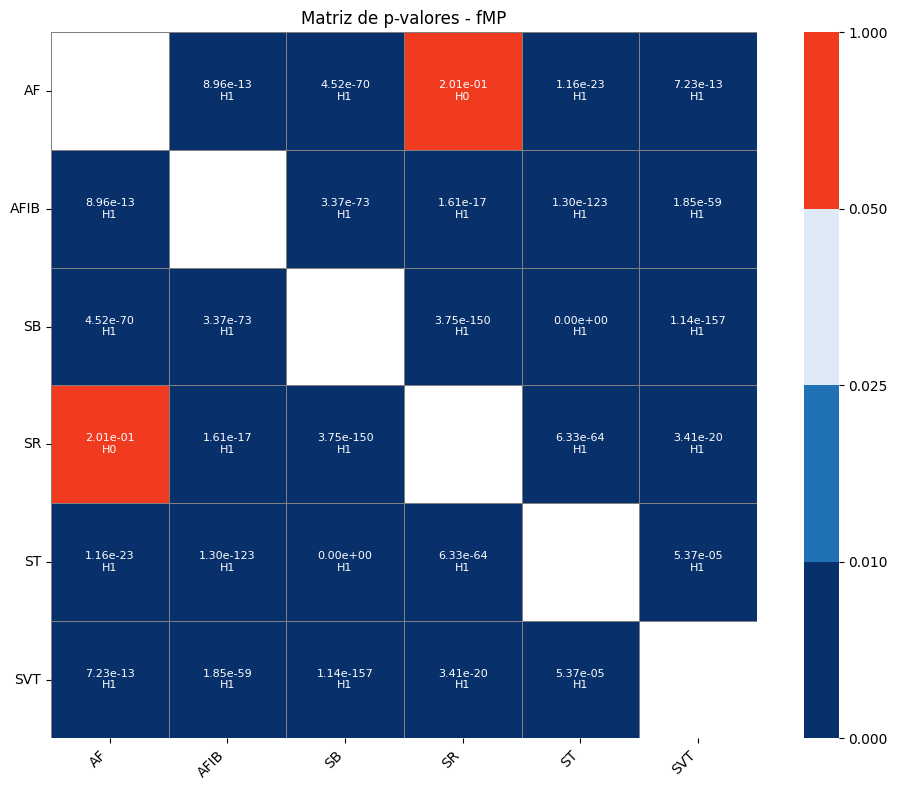


Promedio de p-valores (excluyendo la diagonal): 0.0004


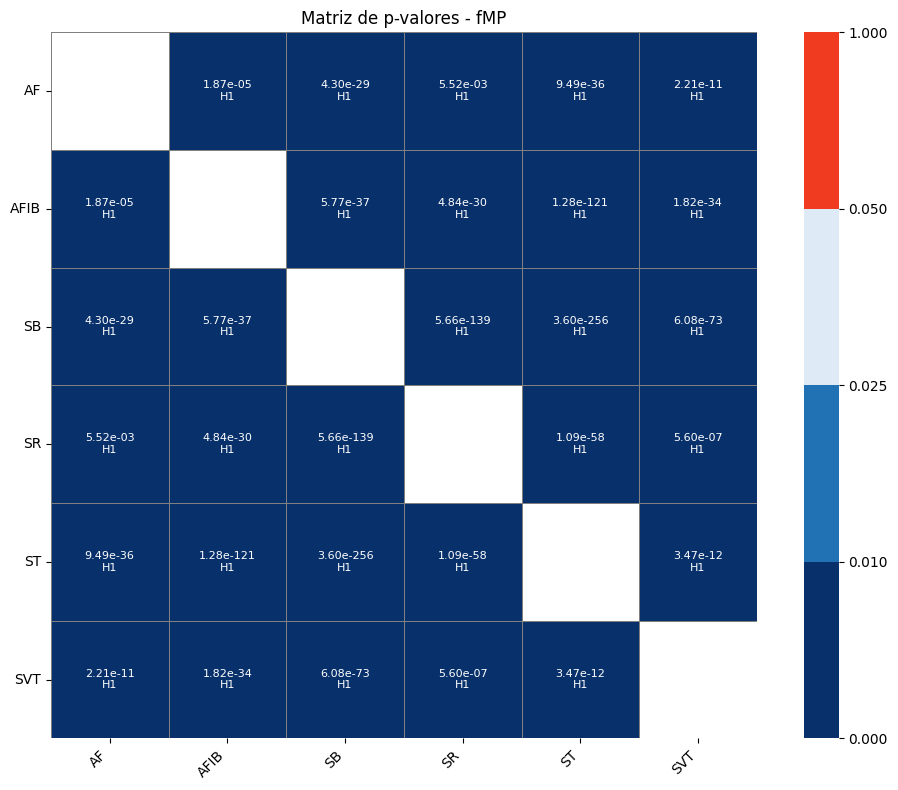

In [ ]:
matriz_comparativa(df_full_fmp, metrica='fMP')
matriz_comparativa(df_full_fmp_denoised, metrica='fMP')